<a href="https://colab.research.google.com/github/dpk-a7/Deep-learning/blob/main/toxic_comment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
# !kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
# !wget http://nlp.stanford.edu/data/glove.6B.zip

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [13]:
!pip install -q kaggle
!pip install -q kaggle-cli
!mkdir -p ~/.kaggle
!cp "kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json# For competition datasets
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-xo0pjm22/lxml/setup.py'"'"'; __file__='"'"'/tmp/pip-install-xo0pjm22/lxml/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-64f0a3bi/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.
{"username":"deepakavudiappan","key":"f85a7e006b065d4a782c1ab2b3ff214e"}chmod: cannot access '/root/.kaggle/kaggle.json#': No such file or directory
chmod: cannot access 'For': No such file or directory
chmod: cannot access 'competition': No such file or directory
chmod: cannot access 'datasets': No such file or directory
100% 26.3M/26.3M [00:00<00:00, 117MB/s]

 38% 9.00M

In [14]:
# !unzip glove.6B.zip
!unzip train.csv.zip
!unzip test.csv.zip

Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                


In [15]:
from __future__ import print_function, division
from builtins import range

In [16]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer # individual component in a sentence like(words,punctuation)
from keras.preprocessing.sequence import pad_sequences # normalize length
from keras.layers import Dense, Input, GlobalMaxPool1D
from keras.layers import Conv1D, MaxPool1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score # area under curve matric which is useful for binary classification

In [17]:
MAX_SEQ_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10

In [18]:
#loading word vectors..
word2vec = {} #key = word: value = vectors
with open(os.path.join("glove.6B.%sd.txt" % EMBEDDING_DIM)) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype= 'float32')
    word2vec[word] = vec
print("found %s word vectors" % len(word2vec))

found 400000 word vectors


In [19]:
word2vec['the']

array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
       -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
        0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
       -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
        0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
       -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
        0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
        0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
       -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
       -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
       -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
       -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
       -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
       -1.2526  ,  0.071624,  0.70565 ,  0.49744 , 

In [21]:
#Loading comments
train = pd.read_csv("train.csv")
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [22]:
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ['toxic', 'severe_toxic', 'obscene',
                   'threat','insult', 'identity_hate']
targets = train[possible_labels].values

In [23]:
print("max sequence length:",max(len(s)for s in sentences))
print("min sequence length:",min(len(s)for s in sentences))
s = sorted(len(s) for s in sentences)
print("median sequence length:", s[len(s)//2]) 

max sequence length: 5000
min sequence length: 6
median sequence length: 205


In [24]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

In [25]:
word2idx = tokenizer.word_index
print("found %s unique tokens" % len(word2idx))

found 210337 unique tokens


In [26]:
data = pad_sequences(sequences, maxlen = MAX_SEQ_LENGTH)
print("Shape of data tensor:", data.shape)

Shape of data tensor: (159571, 100)


In [28]:
print("Filling pre-trained embeddings..")
num_words = min(MAX_VOCAB_SIZE, len(word2idx)+1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings..


In [31]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQ_LENGTH,
    trainable = False
)

In [34]:
input_ = Input(shape=(MAX_SEQ_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128,3,activation = 'relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(128,3,activation = 'relu')(x)
x = MaxPool1D(3)(x)
x = Conv1D(128,3,activation = 'relu')(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation="sigmoid")(x)

model = Model(input_, output)
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [35]:
history = model.fit(
    data,
    targets,
    batch_size = BATCH_SIZE,
    epochs= EPOCHS,
    validation_split= VALIDATION_SPLIT
)

Epoch 1/10
998/998 [==============================] - 128s 112ms/step - loss: 0.1065 - accuracy: 0.9533 - val_loss: 0.0720 - val_accuracy: 0.9941
Epoch 2/10
998/998 [==============================] - 113s 113ms/step - loss: 0.0687 - accuracy: 0.9924 - val_loss: 0.0676 - val_accuracy: 0.9941
Epoch 3/10
998/998 [==============================] - 112s 113ms/step - loss: 0.0619 - accuracy: 0.9930 - val_loss: 0.0689 - val_accuracy: 0.9929
Epoch 4/10
998/998 [==============================] - 111s 111ms/step - loss: 0.0600 - accuracy: 0.9930 - val_loss: 0.0665 - val_accuracy: 0.9937
Epoch 5/10
998/998 [==============================] - 113s 113ms/step - loss: 0.0569 - accuracy: 0.9932 - val_loss: 0.0909 - val_accuracy: 0.9930
Epoch 6/10
998/998 [==============================] - 111s 111ms/step - loss: 0.0545 - accuracy: 0.9937 - val_loss: 0.0814 - val_accuracy: 0.9936
Epoch 7/10
998/998 [==============================] - 111s 111ms/step - loss: 0.0539 - accuracy: 0.9932 - val_loss: 0.0804 -

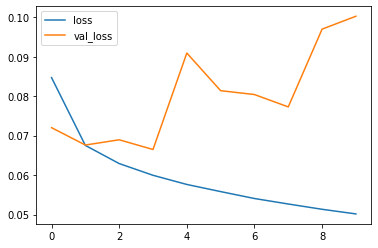

In [36]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show();

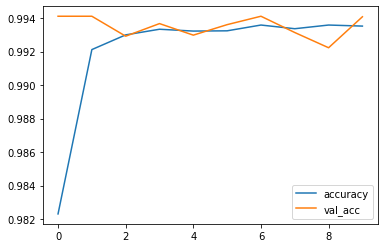

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show();

In [38]:
p = model.predict(data)
aucs = []
del i
for i in range(5):
  auc = roc_auc_score(targets[:,i], p[:,i])
  aucs.append(auc)
print(np.mean(aucs))

0.9761961465346959
